## Simulate some planets

In [30]:
# %load_ext autoreload
# %autoreload 2
from psisim import telescope,instrument,observation,spectrum,universe,plots
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import copy
import time
from astropy.io import fits
import astropy.units as u
import pysynphot as ps

### Set up the telescope and instrument configuration

In [31]:
gemini = telescope.GeminiSouth()
gpi = instrument.GPI()
wvs,dwvs = gpi.get_effective_wavelength('H')
R = wvs/dwvs
gpi.set_observing_mode(60,38,'H',R,wvs,dwvs)

### Generate planets around stars studied in GPIES

The planet table has all the planet and host star properties, which we will use going forward

In [32]:
uni = universe.GPIES_Universe()
planet_table = uni.simulate_GPIES_Universe()
#This step expects wvs in
min_iwa = .12# in arcseconds
owa = 1.9 # in arcseconds
print(len(planet_table))
planet_table = planet_table[planet_table['AngSep'].to(u.arcsec).value > min_iwa]
planet_table = planet_table[planet_table['AngSep'].to(u.arcsec).value < owa]
planet_table = planet_table[planet_table['PlanetMass'].to(u.Mjup).value < 80]
print(len(planet_table))
# planet_table = planet_table[planet_table['Flux Ratio'] > 1e-10] # this is a rough planet contrast estimated by EXOSIMS
n_planets = len(planet_table)
if n_planets == 0:
    raise ValueError('No planets were generated in outside the IWA and inside the OWA.')

331
162


### We'll pick random planets, since many systems are multi-planet systems and they show up  sequentially in EXOSIMS



In [33]:
planet_types = []
planet_spectra = []
absolute_mags = []
n_planets_now = len(planet_table) # how many 

## Generate spectra

We will use a simple cloudy Jupiter model right now.

In [34]:
print("\n Starting to generate planet spectra")
for planet in planet_table:
    #INSERT PLANET SELECTION RULES HERE
    planet_type = "Gas"
    planet_types.append(planet_type)

    time1 = time.time()
    #Generate the spectrum and downsample to intermediate resolution
    
    ## get_stellar_spectrum expects wvs in microns
    planet_spectrum= spectrum.get_stellar_spectrum(planet,[wvs.value]*wvs.unit,R,model='COND+BTSettle_Broadband',verbose=False,user_params = None,doppler_shift=False,broaden=False,delta_wv=None)
    planet_spectra.append(planet_spectrum)
    time2 = time.time()
    print('Spectrum took {0:.3f} s'.format((time2-time1)))

print("Done generating planet spectra")


 Starting to generate planet spectra
Spectrum took 0.074 s
Spectrum took 0.067 s
Spectrum took 0.060 s
Spectrum took 0.075 s
Spectrum took 0.062 s
Spectrum took 0.059 s
Spectrum took 0.068 s
Spectrum took 0.071 s
Spectrum took 0.064 s
Spectrum took 0.065 s
Spectrum took 0.071 s
Spectrum took 0.071 s
Spectrum took 0.063 s
Spectrum took 0.065 s
Spectrum took 0.071 s
Spectrum took 0.076 s
Spectrum took 0.066 s
Spectrum took 0.066 s
Spectrum took 0.072 s
Spectrum took 0.069 s
Spectrum took 0.058 s
Spectrum took 0.065 s
Spectrum took 0.069 s
Spectrum took 0.072 s
Spectrum took 0.033 s
Spectrum took 0.060 s
Spectrum took 0.061 s
Spectrum took 0.064 s
Spectrum took 0.071 s
Spectrum took 0.066 s
Spectrum took 0.060 s
Spectrum took 0.063 s
Spectrum took 0.063 s
Spectrum took 0.067 s
Spectrum took 0.067 s
Spectrum took 0.063 s
Spectrum took 0.063 s
Spectrum took 0.068 s
Spectrum took 0.068 s
Spectrum took 0.057 s
Spectrum took 0.063 s
Spectrum took 0.060 s
Spectrum took 0.060 s
Spectrum took 0.

## Simulate the observations and calculate the SNR of the observation

In [35]:
print("\n Starting to simulate observations")

planet_spectra = np.array(planet_spectra)
planet_table['StarAOmag'] = planet_table['StarHmag']
post_processing_gain = []
for i in range(len(planet_table)):
    post_processing = gpi.get_post_processing_gain(planet_table['AngSep'][i])
    post_processing_gain += [post_processing]
sim_F_lambda, sim_F_lambda_errs, sim_F_lambda_stellar, noise_components = observation.simulate_observation_set(gemini,gpi, planet_table, planet_spectra, [wvs.value]*wvs.unit, R, inject_noise=False,post_processing_gain=post_processing_gain,return_noise_components=True)
speckle_noises = noise_components[:,0]
photon_noises = noise_components[:,2]
flux_ratios = np.divide(sim_F_lambda,sim_F_lambda_stellar)
detection_limits = np.divide(sim_F_lambda_errs,sim_F_lambda_stellar)
snrs = np.divide(sim_F_lambda,sim_F_lambda_errs)
snrs = snrs[:,None]
detected = gpi.detect_planets(planet_table,snrs)


 Starting to simulate observations
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
electron
e

## Plot the Planets.

(1e-09, 0.1)

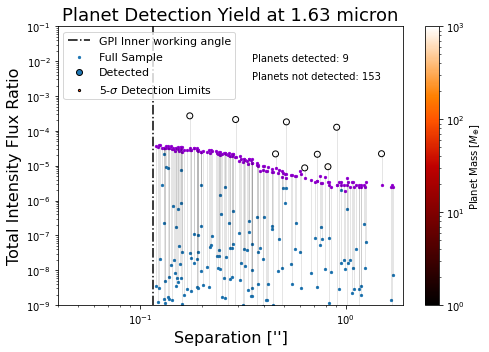

In [36]:
 #Choose which wavelength you want to plot the detections at:
wv_index = 0
gpi.current_wvs = gpi.current_wvs[None]
detection_limits = detection_limits[:,None]
fig, ax = plots.plot_detected_planet_contrasts(planet_table,wv_index,
    detected,flux_ratios[:,None],gpi,gemini,ymin=1e-9,ymax=.1,xmin=.04,xmax=1.9,alt_data=5*detection_limits,alt_label=r"5-$\sigma$ Detection Limits", show=False)

#The user can now adjust the plot as they see fit. 
#e.g. Annotate the plot
ax.text(.35,10e-3,"Planets detected: {}".format(len(np.where(detected[:,wv_index])[0])),color='k')
ax.text(.35,30e-4,"Planets not detected: {}".format(len(np.where(~detected[:,wv_index])[0])),color='k')
# ax.text(4e-7,0.015625e-5,"Post-processing gain: {}".format(post_processing_gain),color='k')
plt.xlim(.04,1.9)
plt.ylim(1e-9,.1)